# Домашняя работа 3: Разработка модели детектирования объектов

##  Грачев Денис Вадимович


На семинаре мы обсудили, разработали и попробовали `SSD` модель на базе `VGG16`, поэтому для успешного выполнения домашнего задания рекомендуется обратиться к семинару.

Задачи домашнего задания:
 - Загрузить набор данных и визуализировать объекты. (2 балла)
 - Разработать функцию для расчета метрики mAP задачи детектирования объектов. Продемонстрировать работу. (4 балла)
 - Натренировать `SSD` модель на базе VGG16. Продемонстрировать повышение метрики mAP (4 балла)
 - Разработать `SSD` модель согласно предлагаемой архитектуры на базе `ResNet18`. Продемонстрировать повышение метрики mAP (10 баллов)
 - (БОНУС) Добавить разнообразные аугментации изображений. Можно позаимствовать из других репозитариев с указанием источника. Повторить эксперименты (5 баллов)

## Описание предлагаемых исходных кодов
- voc_dataset.py     - загружает предлагаемый набор данных, здесь также возможно выполнять аугментации над данными.
- voc_dataloader.py  - формирует порцию данных.
- prior_boxes.py     - содержит все необходимые функции для работы с `prior` боксами.
    - prior_boxes - функция генерирует `prior` боксы в соотвествии с конфигурацией
    - match       - функция решает задачу сопоставления `ground truth` боксов из набора данных и `prior` боксов
    - decode      - функция вычисляет поправки между `ground truth` боксами и `prior` боксами, собственно их будет *предсказывать* наша модель
    - encode      - функция пересчитывает `prior` боксы и *предсказанные* поправки в результирующие детектирования

- model_vgg16.py   - реализация `SSD` на базе VGG16, которая рассматривалась на семинаре.
- multibox_loss.py - комплексная функция потерь, решается задача сопоставления *предсказанных* и `ground truth` боксов, применяется техника `hard-negative mining`, вычисляется общая функция потерь.

- train_model.py    - пример, который тренирует модель детектирования.
- evaluate_model.py - пример, который визуализирует результат работы модели детектирования.

## Архитектура модели на основе VGG16

Обязательно посмотрите реализацию и разберитесь в том, как устроенна модель, это будет полезно при разработке собственной модели детектирования.

![Image](output_vgg16.png)

## Архитектура модели на основе ResNet18

Можно исследовать реализацию ResNet в пакете PyTorch, это будет полезно при разработке собственного детектора.

https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py

![Image](output_resnet18.png)

In [1]:
%load_ext autoreload
%autoreload

In [2]:
import numpy as np

import argparse
import torch
import torchvision
from torchmetrics.detection import MeanAveragePrecision
import time
import os

/home/denis/miniconda3/envs/ml3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/denis/miniconda3/envs/ml3/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c107WarningC1ENS_7variantIJNS0_11UserWarningENS0_18DeprecationWarningEEEERKNS_14SourceLocationENSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEEb'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:

from voc_dataloader import get_train_dataloader, get_test_dataloader
from voc_dataset import VOC_CLASSES

from model_vgg16     import SSD_VGG16
from multibox_loss   import MultiBoxLoss
from prior_boxes     import prior_boxes
from logger          import Logger

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib import patches,  lines
from voc_dataset import default_mean, default_std
import colorsys
import random

/home/denis/miniconda3/envs/ml3/lib/python3.9/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/denis/miniconda3/envs/ml3/lib/python3.9/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feed

## Создаем конфигурацию, которая описывает работы нашего детектора (пример для VGG16)

In [4]:
#VGG16
custom_config = {
 'num_classes'  : 3,
 'feature_maps' : [(90,160), (45,80), (23,40), (12,20), (10,18), (8,16)], #Размерность карт признаков, которые будут использоваться
 'min_sizes'    : [0.10, 0.20, 0.37, 0.54, 0.71, 1.00],
 'max_sizes'    : [0.20, 0.37, 0.54, 0.71, 1.00, 1.05],
 
 'aspect_ratios': [[2, 3], [2, 3], [2, 3], [2, 3], [2], [2]], #Список содержаший информацию о соотношении сторон для prior боксов
 'num_priors'   : [6, 6, 6, 6, 4, 4], #Число prior боксов
 'variance'     : [0.1, 0.2],
 'clip'         :    True,

 'overlap_threshold': 0.5, #Параметр IoU
 'neg_pos_ratio'    :   3, #Параметр hard-negative mining

 'model_name' : 'vgg16'
}


## Загружаем требуемый набор данных

In [5]:
def tensor_to_image(tensor, mean=(0.5, 0.5, 0.5), std=(0.25, 0.25, 0.25)):
    # mean, std ->
    mean = torch.tensor(mean)[:, None, None]
    std = torch.tensor(std)[:, None, None]

    renormalized_tensor = mean + std * tensor
    image = renormalized_tensor.permute(1, 2, 0).detach().cpu().numpy()

    return image

In [6]:
def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] * (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

In [7]:
def visualize(image, boxes, class_ids, class_names, scores=None, title="Segmented objects", figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True, colors=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    """
    # Number of instances
    N = boxes.shape[0]

    #генерим случайные цвета для разных масок
    colors = colors or random_colors(N)

    _, ax = plt.subplots(1, figsize=figsize)
    ax.axis('off')
    ax.set_title(title)

    # masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]
        #рисуем бокс
        x1, y1, x2, y2 = boxes[i]

        x1 = (x1 + 0.0) * image.shape[1]
        x2 = (x2 + 0.0) * image.shape[1]
        y1 = (y1 + 0.0) * image.shape[0]
        y2 = (y2 + 0.0) * image.shape[0]

        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, alpha=0.7,
                                 linestyle="dashed", edgecolor=color, facecolor='none')
            ax.add_patch(p)

        #подпись класса
        class_id = class_ids[i]
        score = scores[i] if scores is not None else None
        label = class_names[class_id]
        caption = "{} {:.3f}".format(label, score) if score else label
        ax.text(x1, y1 + 8, caption, color='w', size=11, backgroundcolor="none")

        #рисуем маску
        # mask = masks[i, :, :]
        # if show_mask:
        #     masked_image = apply_mask(masked_image, mask, color)

    ax.imshow(image)
    plt.show()

In [8]:
voc_root = "dataset"
    
train_annotation_filename = os.path.join( voc_root, "ImageSets/Main/trainval.txt" )
test_annotation_filename  = os.path.join( voc_root, "ImageSets/Main/test.txt"     )

train_dataloader = get_train_dataloader(voc_root, train_annotation_filename, 16, 8) 
test_dataloader  = get_test_dataloader(voc_root, test_annotation_filename, 16, 8)

In [9]:
test = next(iter(train_dataloader))

In [10]:
xs, boxes, labels = test

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


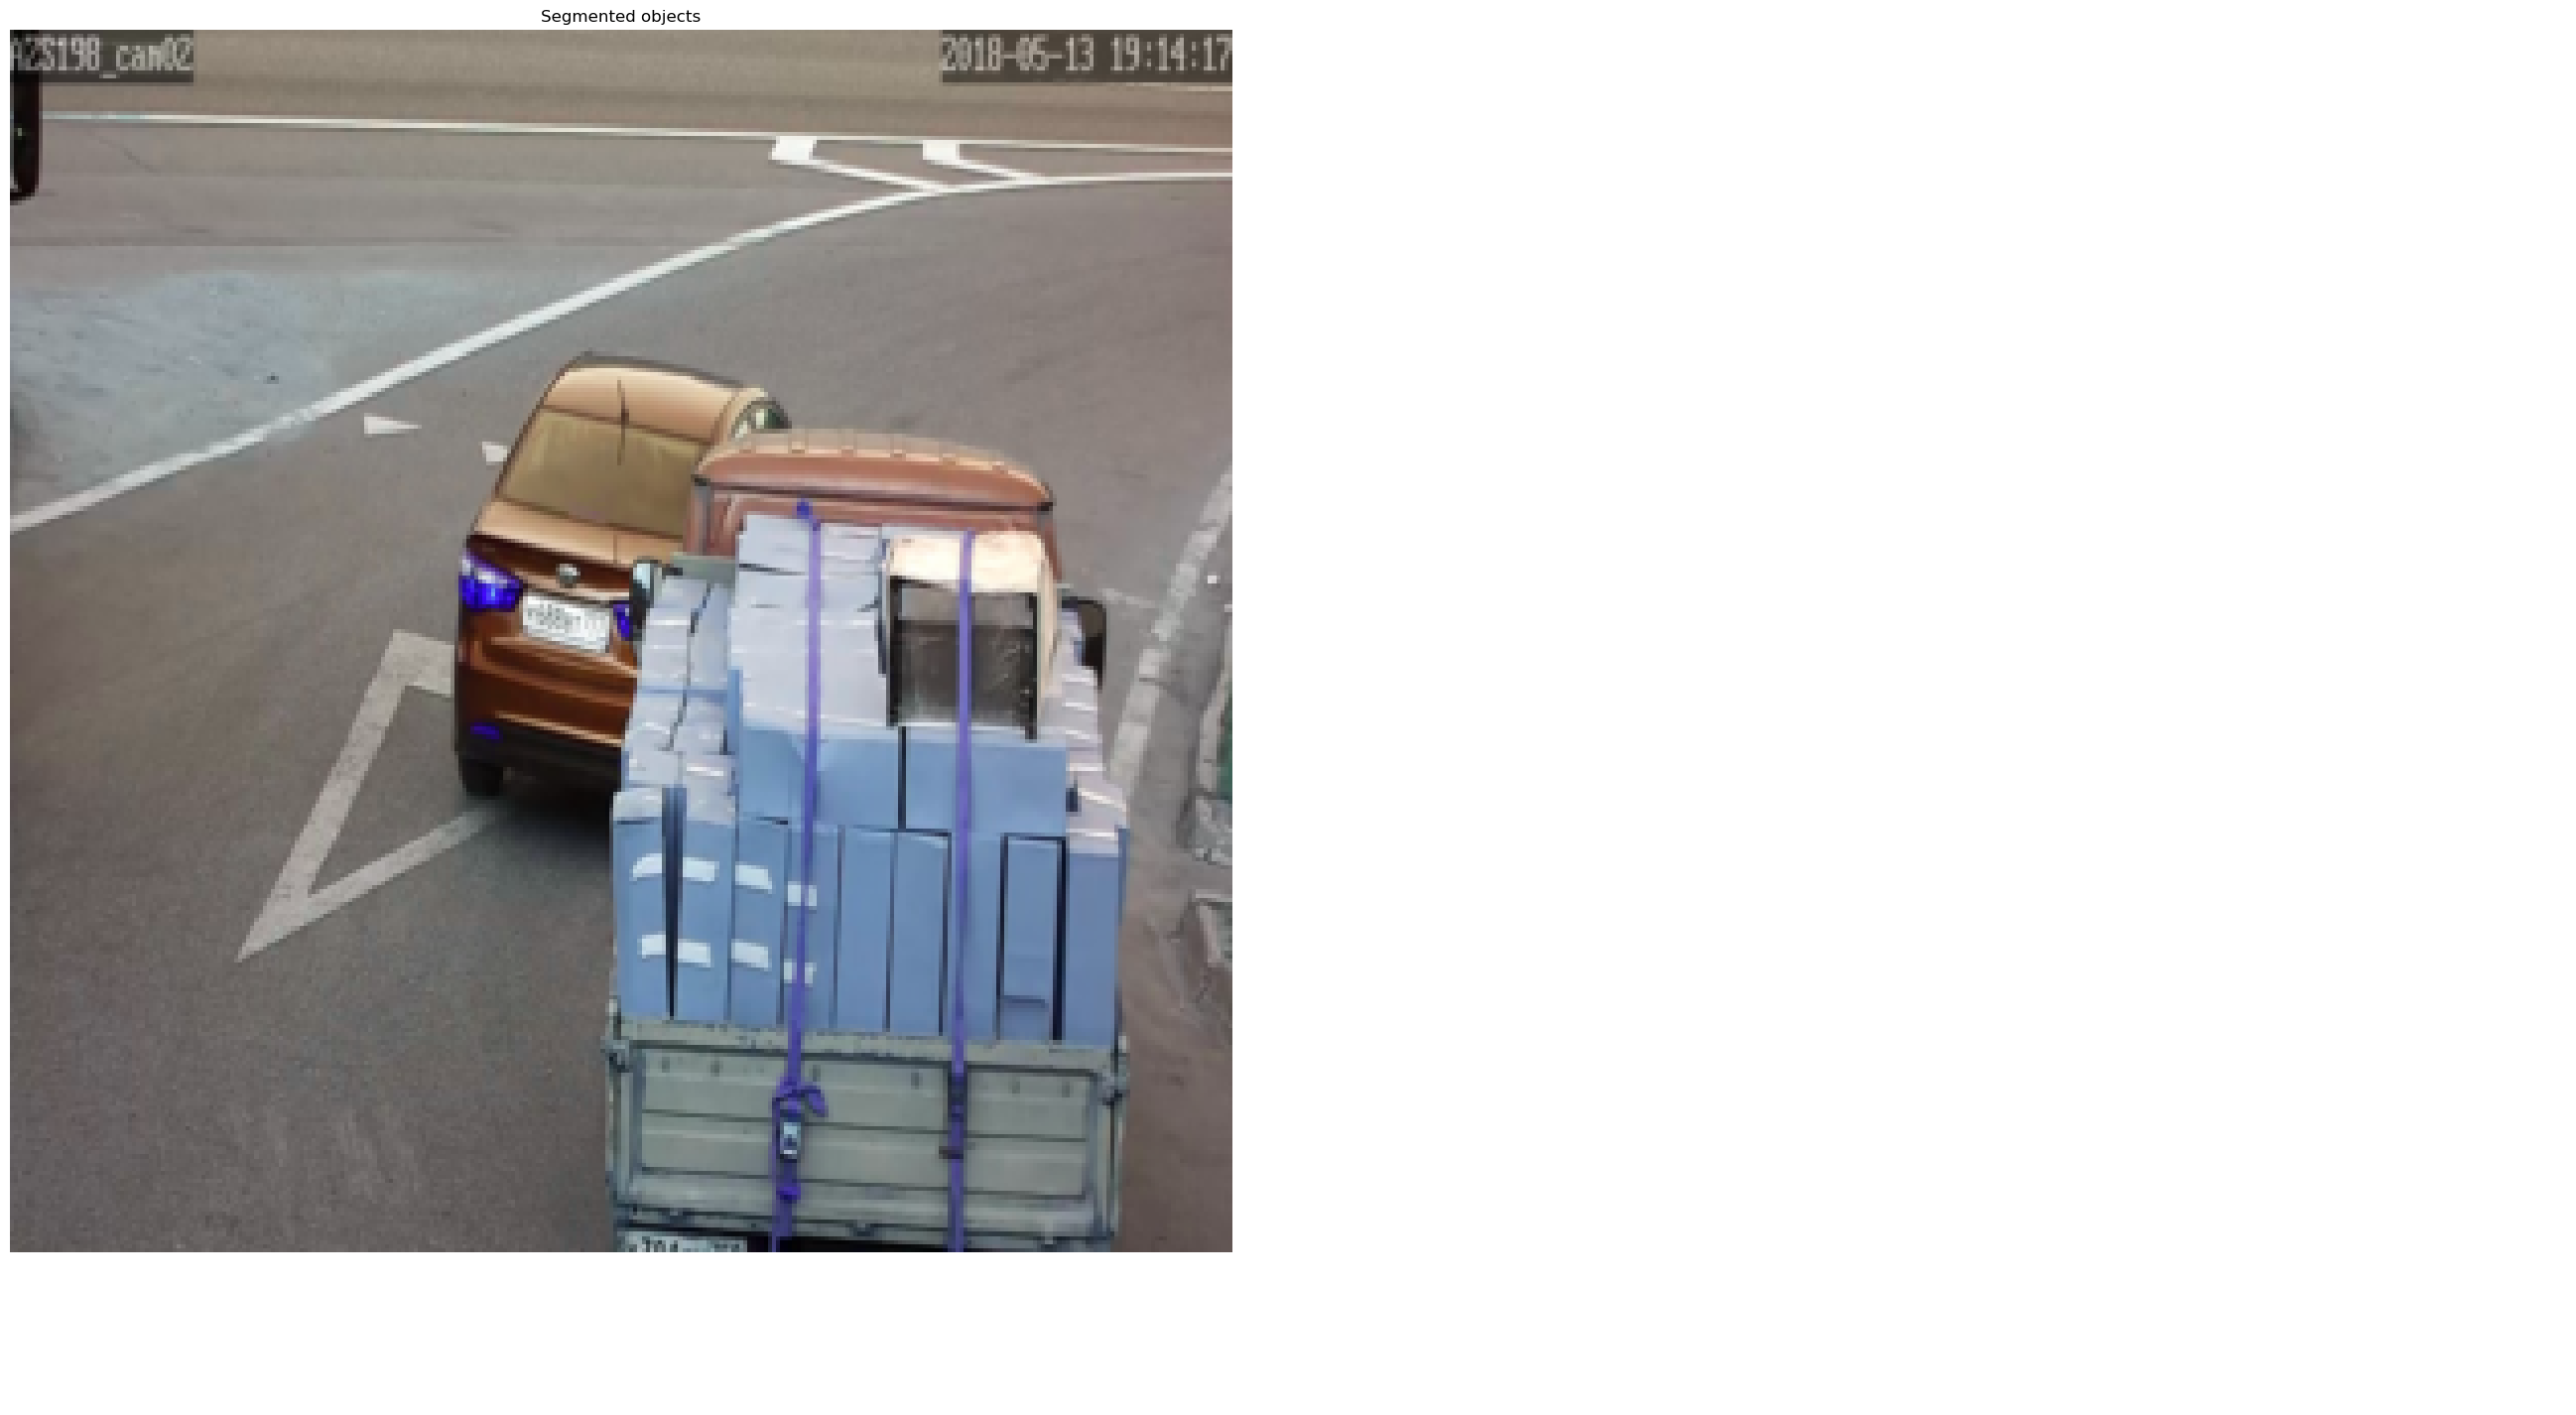

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


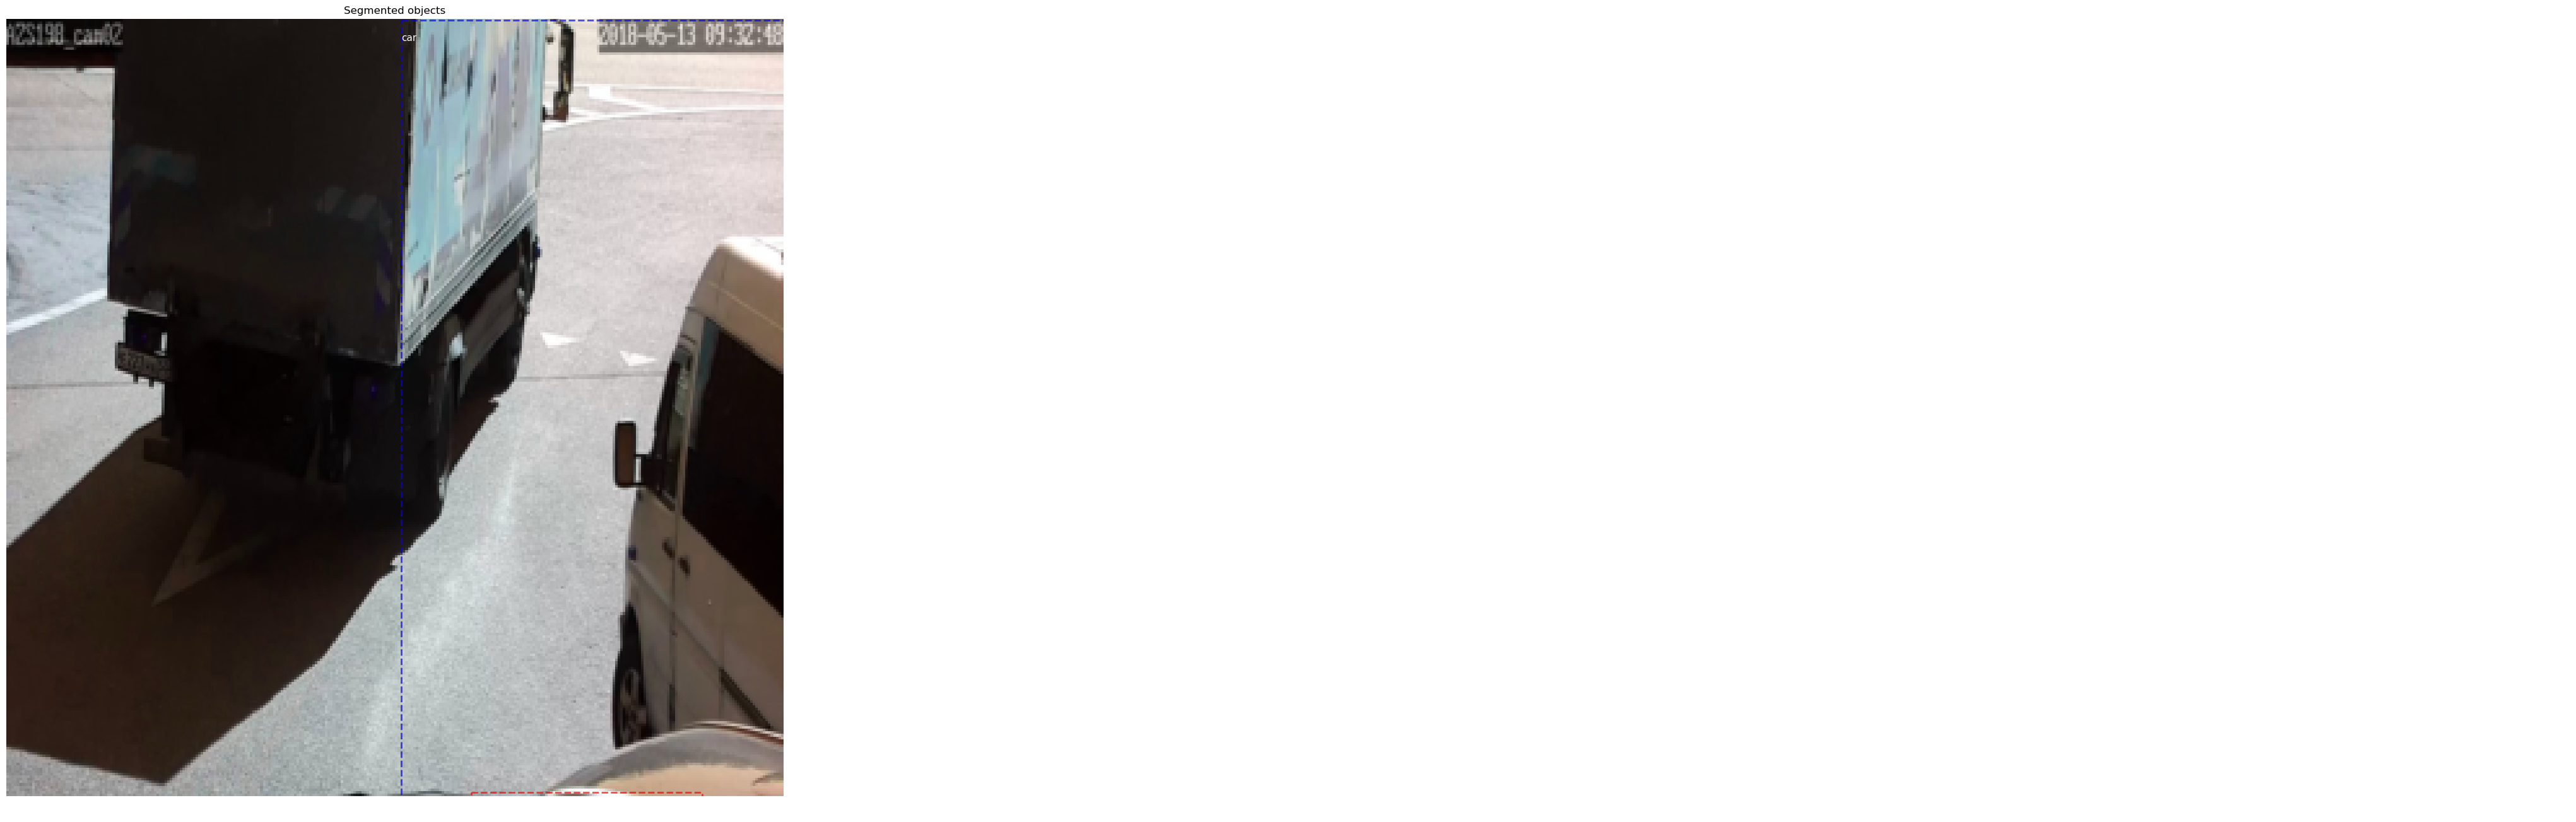

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


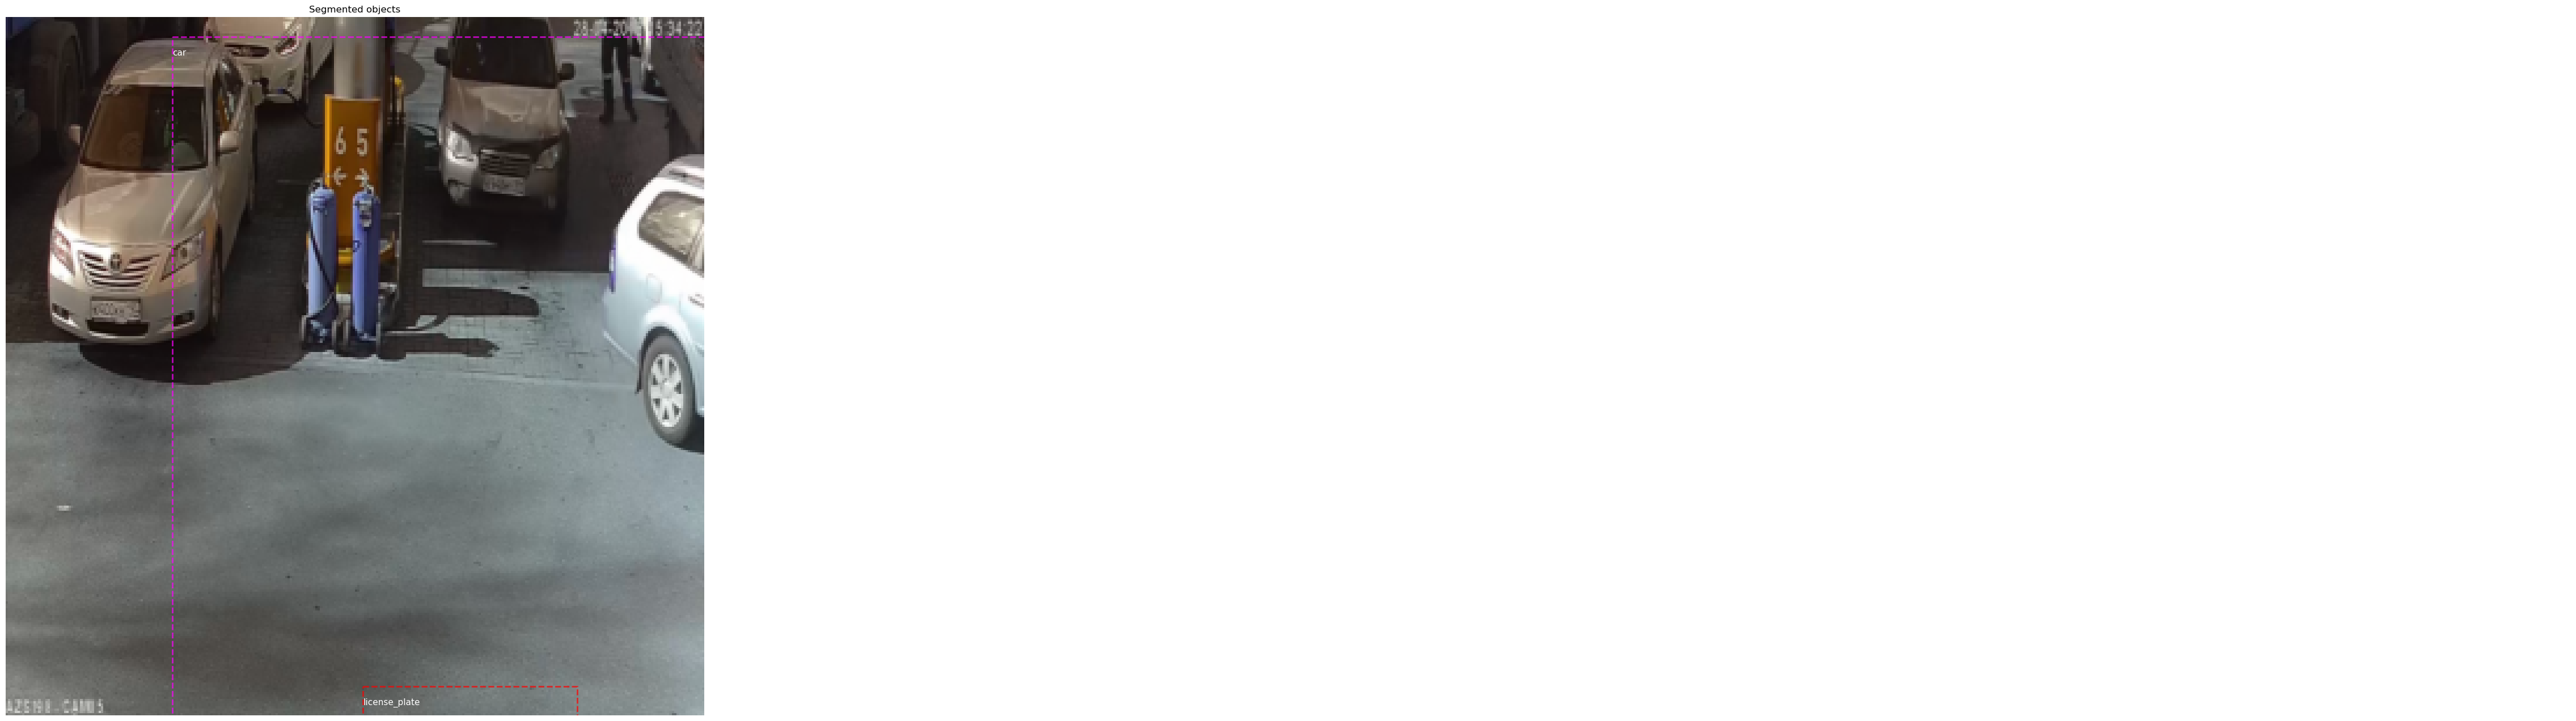

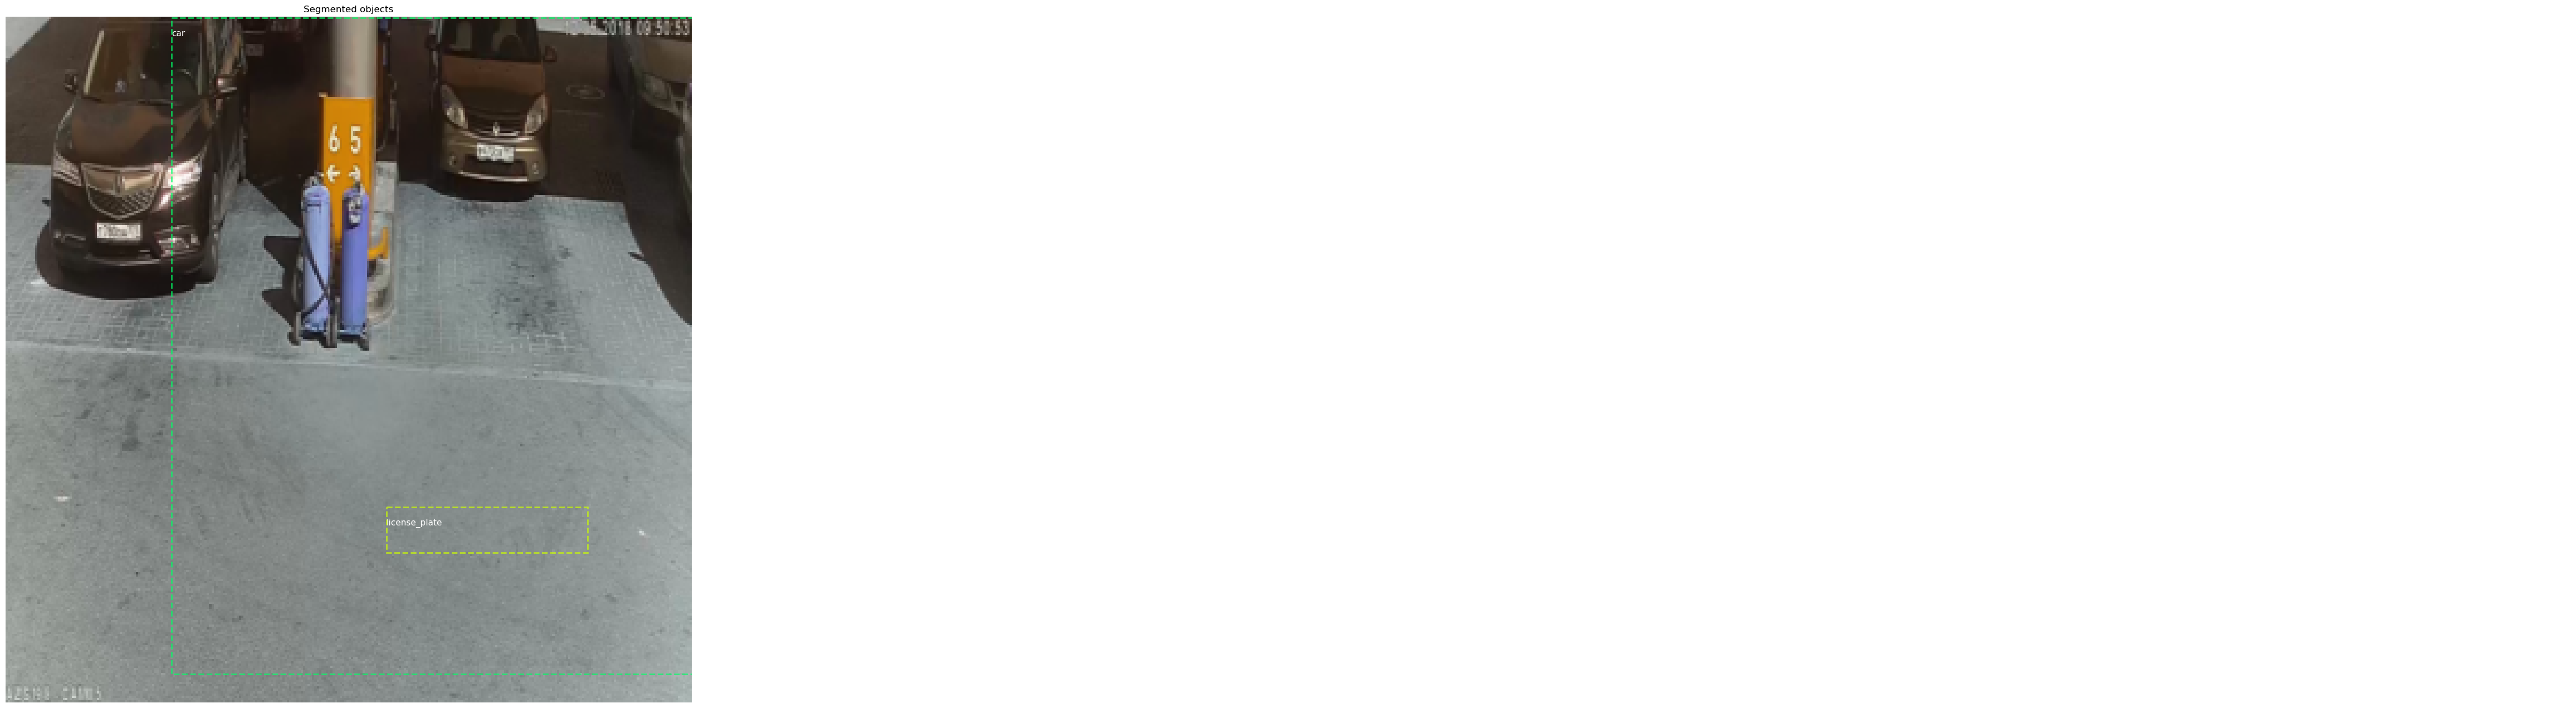

In [11]:
for i in range(4):
    visualize(
        tensor_to_image(xs[i], default_mean, default_std), 
        boxes[i],  
        labels[i], 
        VOC_CLASSES
    )

## Разработать функцию вычисление mAP метрики задачи детектирования

## Average precision

In [12]:
num_classes = 2

In [13]:
batch_pred_boxes = boxes
batch_scores = [torch.rand(len(boxes)) for boxes in batch_pred_boxes]

batch_true_boxes = boxes
batch_true_labels = labels
threshold = 0.3

In [14]:
def batch_average_precision(batch_pred_boxes, batch_scores, batch_true_boxes, threshold):
    number_of_predictions = sum(len(boxes) for boxes in batch_pred_boxes)
    batch_is_active = []

    for pred_boxes, pred_scores, true_boxes in zip(batch_pred_boxes, batch_scores, batch_true_boxes):
        ious = torchvision.ops.box_iou(pred_boxes, true_boxes)
        max_iou_value, max_iou_arg = ious.max(dim=0)

        active_index = max_iou_arg[max_iou_value > threshold]
        inactive_index = max_iou_arg[max_iou_value <= threshold]

        detected = torch.zeros(len(pred_boxes))
        detected[active_index] = 1
        detected[inactive_index] = 0

        batch_is_active.append(detected)

    batch_scores = torch.cat(batch_scores)
    batch_is_active = torch.cat(batch_is_active)

    score_sort = torch.argsort(batch_scores)
    batch_scores[score_sort]
    batch_is_active[score_sort]

    f_presision = torch.cumsum(batch_is_active, dim=0) / torch.arange(1, len(batch_is_active) + 1)
    f_recall = torch.cumsum(batch_is_active, dim=0) / (number_of_predictions - 1)

    b_presision = torch.flip(f_presision, dims=(0,))
    b_recall = torch.flip(f_recall, dims=(0,))

    b_y, _ = torch.cummax(b_presision, 0)
    b_x = b_recall

    f_y = torch.flip(b_y, dims=(0,))
    f_x = torch.flip(b_x, dims=(0,))

    dx = f_x[1:] - f_x[:-1]

    a_p = torch.sum(f_y[:-1] * dx)

    return a_p.item()

batch_average_precision(batch_pred_boxes, batch_scores, batch_true_boxes, threshold)

1.0

## Mean average precision

In [15]:
def mean_average_precision(batch_pred_boxes, batch_scores, batch_true_boxes, batch_true_labels, threshold):
    
    classes = torch.unique(torch.cat(batch_true_labels))
    aps = []

    for i_class in classes:
        ids = [labels == i_class for labels in batch_true_labels]


        batch_pred_boxes_class = [pb[ids] for ids, pb in zip(ids, batch_pred_boxes)]
        batch_scores_class = [s[ids] for ids, s in zip(ids, batch_scores)]
        batch_true_boxes_class = [tb[ids] for ids, tb in zip(ids, batch_true_boxes)]

        aps.append(batch_average_precision(batch_pred_boxes_class, batch_scores_class, batch_true_boxes_class, threshold))

    return np.mean(aps)

In [16]:
mean_average_precision(batch_pred_boxes, batch_pred_boxes, batch_true_boxes, batch_true_labels, 0.3)

0.9999999403953552

## Натренировать модель на основе VGG16

In [17]:
from model_vgg16 import SSD_VGG16
from torchview import draw_graph

In [18]:
num_bboxes_s = [6, 6, 6, 6, 6, 6]

model = SSD_VGG16(num_bboxes_s, 3)
model.eval()
    
input_data  = torch.randn(1, 3, 720, 1280, dtype=torch.float, requires_grad=False)
output_locs, output_confs = model( input_data )

model_graph  = draw_graph(model, input_size=(1,3,720,1280), expand_nested=True)
visual_graph = model_graph.visual_graph
graph_svg = visual_graph.pipe(format='png')
with open('output_vgg16.png', 'wb') as f:
    f.write(graph_svg)

print(output_locs .shape)
print(output_confs.shape)


torch.Size([1, 116808, 4])
torch.Size([1, 116808, 3])


In [19]:
from train_model import train_process

In [20]:
args = {
    'dataset_root_dir' : 'dataset/',
    'epochs' : 20,
    'batch_size' : 16,
    'checkpoint' : None,
    'output' : 'output',
    'multistep' : [20, 40, 60],
    'learning_rate' : 1e-4,
    'momentum' : 0.9,
    'weight_decay' : 0.0001,
    'warmup' : None,
    'num_workers' : 2,
    'seed' : 42,
}

custom_config = {
    'num_classes'  : 3,
    'feature_maps' : [(38,38), (19,19), (10,10), (5,5), (3,3), (1,1)], #VGG16
    'min_sizes'    : [0.10, 0.20, 0.37, 0.54, 0.71, 1.00],
    'max_sizes'    : [0.20, 0.37, 0.54, 0.71, 1.00, 1.05],

    'aspect_ratios': [[2, 3], [2, 3], [2, 3], [2, 3], [2], [2]],
    'num_priors'   : [6, 6, 6, 6, 4, 4],
    'variance'     : [0.1, 0.2],
    'clip'         :    True,

    'overlap_threshold': 0.5,
    'neg_pos_ratio'    :   3,

    'model_name' : 'vgg16'
}



In [21]:
torch.cuda.empty_cache()
model, model_st_dict = train_process(custom_config, args)

  0%|          | 0/20 [00:01<?, ?it/s]


RuntimeError: The expanded size of the tensor (11620) must match the existing size (116192) at non-singleton dimension 0.  Target sizes: [11620, 4].  Tensor sizes: [116192, 4]

## Разработать модель на основе ResNet18

## Натренировать модель на основе ResNet18

## (БОНУС) Добавить разнообразные аугментации изображений в классе Dataset. Провести эксперименты и продемонстрировать метрику mAP.